### Here is the illustration of the framework:
step 1: pre-trained FBPINN

step 2: POU-RBF for self-adaptive domain decomposition

step 3: FBPINN based on the that domain decomposition

In [2]:
%matplotlib widget           

import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

key = jax.random.PRNGKey(0)

### Step 1:

In [ ]:
from physics.problems import Poisson2D_freq
from utils.data_utils import generate_subdomains, generate_collocation
from model.fbpinn_model import FBPINN           
from train.trainer_fbpinn import train_fbpinn

problem = Poisson2D_freq()
u_exact, ansatz, domain, residual_fn = (
    problem.exact, problem.ansatz, problem.domain, problem.residual
)

DIM           = 2
SUB_PER_DIM   = 2
OVERLAP       = 0.3
N_COLLOC      = 50 # number of points per dim
STEPS_BASE    = 10000
LR_BASE       = 1e-3

# 子域 & collocation
subdomains = generate_subdomains(domain, SUB_PER_DIM, OVERLAP)
colloc     = generate_collocation(domain, N_COLLOC, "random")

mlp_cfg = dict(in_size=DIM, out_size=1, width_size=64, depth=3,
               activation=jax.nn.tanh)

base_model = FBPINN(
    key              = key,
    subdomains       = subdomains,
    mlp_config       = mlp_cfg,
    ansatz           = ansatz,
    residual_fn      = residual_fn,
    fixed_transition = OVERLAP,
)

base_model, loss_hist_base, (l1_steps_base, l1_hist_base) = train_fbpinn(
    model            = base_model,
    colloc_full      = colloc,
    steps            = STEPS_BASE,
    lr               = LR_BASE,
    save_dir         = None,
    checkpoint_every = 0,
)
test_n = 50
gx = jnp.linspace(domain[0][0], domain[1][0], test_n)
gy = jnp.linspace(domain[0][1], domain[1][1], test_n)
mesh = jnp.meshgrid(gx, gy, indexing="ij")
x_test = jnp.stack([mesh[0].ravel(), mesh[1].ravel()], axis=-1)
u_pred = jax.vmap(base_model)(x_test).squeeze()
u_true = u_exact(x_test).squeeze()
l1_err = float(jnp.mean(jnp.abs(u_pred - u_true)))
print(f"Stage-1 L1 (post) = {l1_err:.3e}")


/tmp/ipykernel_104371/1696158247.py:25: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  base_model = FBPINN(
FBPINN: 100%|██████████| 10000/10000 [01:52<00:00, 88.93it/s, loss=1.44e+00]


Stage-1 L1 (post) = 5.495e-02


[vis_2d] stats saved to nb_outputs/20250602_222915/stats.npz

Final L1 error = nan
All figures saved in: /mnt/c/Users/chenwanxin/Documents/GitHub/thesis_project/notebook/nb_outputs/20250602_222915
▶ field_and_error


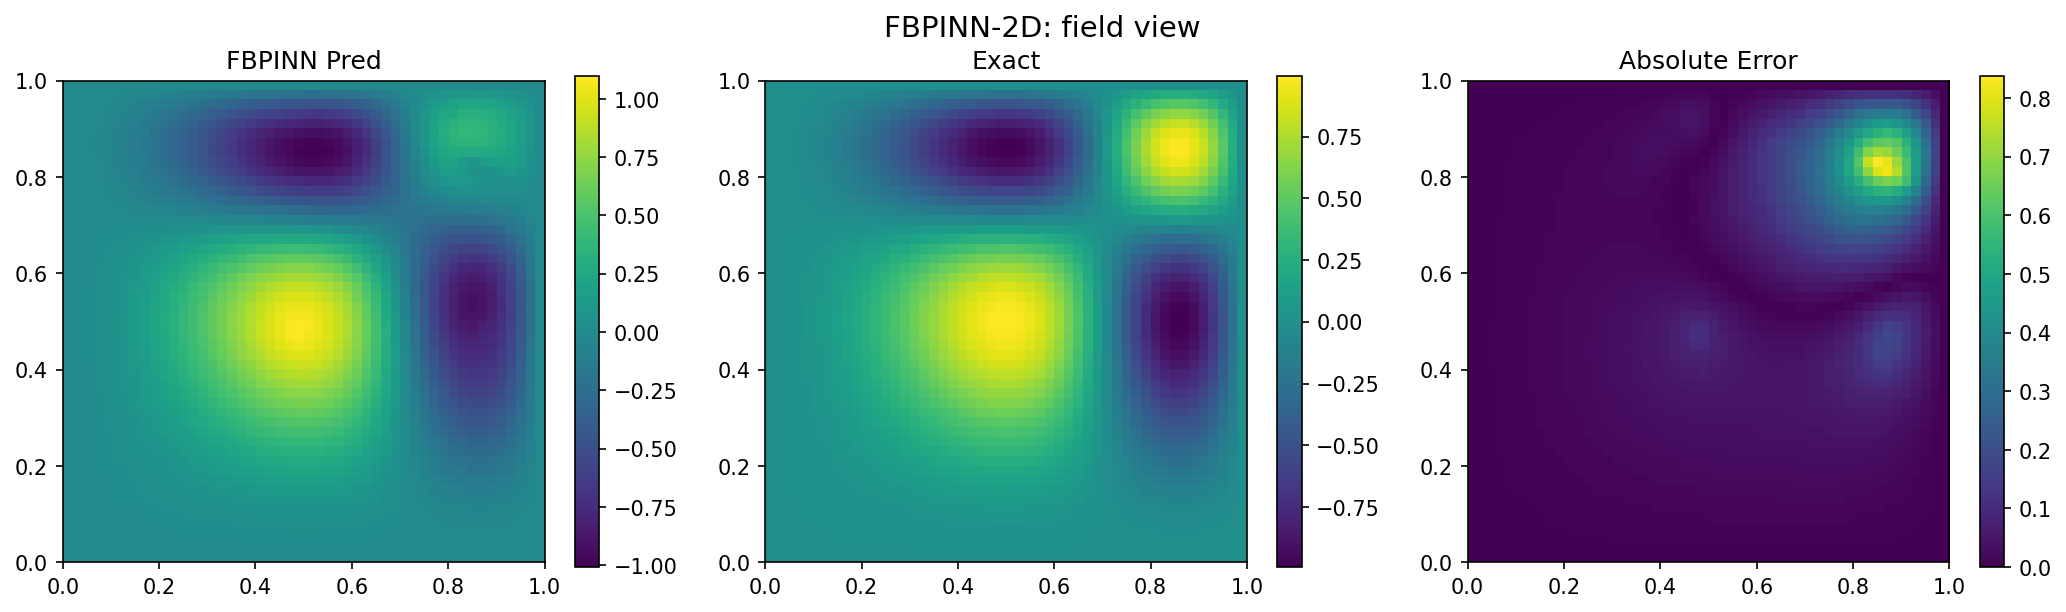

▶ training


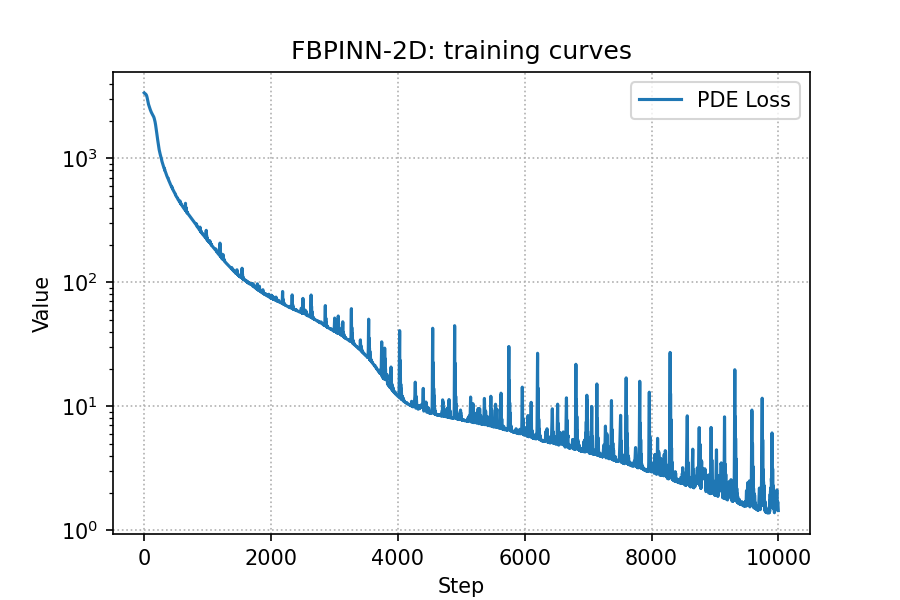

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

xdim = DIM

if xdim == 1:
    print("Visualizing in 1D...")

    # 计算预测值
    u_pred = jax.vmap(base_model)(x_test).squeeze()   # (N,)
    u_true = u_exact(x_test).squeeze()

    # 1D 预测曲线
    plt.figure(figsize=(6,4))
    plt.plot(x_test.squeeze(), u_true, 'k--', label="true")
    plt.plot(x_test.squeeze(), u_pred, label="pred")
    plt.title("Final approximation (1D)")
    plt.legend()
    plt.show()

    # 若有 loss 或 L1 曲线
    if len(l1_steps_base) > 0:
        plt.figure()
        plt.plot(l1_steps_base, l1_hist_base, label="L1 error")
        plt.xlabel("Training steps")
        plt.ylabel("L1 error")
        plt.title("Training error curve")
        plt.legend()
        plt.show()

else:
    print("Visualizing in 2D...")

    # 还原到 (test_n × test_n) 网格
    test_n = int(jnp.sqrt(x_test.shape[0]))      
    grid_x = jnp.linspace(domain[0][0], domain[1][0], test_n)
    grid_y = jnp.linspace(domain[0][1], domain[1][1], test_n)

    u_pred_grid = jax.vmap(base_model)(x_test).squeeze().reshape(test_n, test_n)
    u_true_grid = u_exact(x_test).squeeze().reshape(test_n, test_n)
    err_grid    = jnp.abs(u_pred_grid - u_true_grid)

    # 画三张子图: pred / true / abs err
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    for ax, Z, title in zip(
        axs,
        [u_pred_grid, u_true_grid, err_grid],
        ["pred", "true", "abs err"]
    ):
        im = ax.imshow(Z, origin="lower", extent=(domain[0][0], domain[1][0],
                                                  domain[0][1], domain[1][1]))
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
    plt.show()

    # 若有 loss 或 L1 曲线
    if len(l1_steps_base) > 0:
        plt.figure()
        plt.plot(l1_steps_base, l1_hist_base, label="L1 error")
        plt.xlabel("Training steps")
        plt.ylabel("L1 error")
        plt.title("Training error curve")
        plt.legend()
        plt.show()

# 打印最终的 L1
final_l1 = float(l1_hist_base[-1]) if len(l1_hist_base) else float("nan")
print(f"Final L1 error = {final_l1:.4e}")


In [ ]:
from model.pou_partition_net import PartitionNet
from train.trainer_pou import train_partition_net

# u_baseline 作为监督信号
u_baseline = lambda x: jax.vmap(base_model)(x).squeeze()

part_net = PartitionNet(input_dim=DIM,
                        n_parts=len(subdomains),
                        key=key)

part_net = train_partition_net(
    part_net,
    target_fn=u_baseline,
    domain=domain,
    steps=5000,
    lr=1e-3,
    batch_size=4096,
    key=key,
)
